In [1]:
import numpy as np
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
#anaconda doens't have this package by default
#import it to the environment
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree

#load dataset (compras.txt)

df = pd.read_csv('compras.txt', delimiter='\t')

# for col in df.columns:
#     print(f"Column: {col}")
#     print(df[col].head())
#     print("\n" + "-"*40 + "\n")  # Just a separator for clarity

print(df)

      client       date    weekday  paymethod  value       product
0      11966  27-Dec-97   Saturday       card  22188     fruitvegs
1      12582  03-Dec-97  Wednesday      money  25601   charcuterie
2      13325  25-Dec-97   Thursday       card  41280          fish
3      13722  14-Dec-97     Sunday       card  36217          fish
4      13893  10-Dec-97  Wednesday       card  24804          meat
...      ...        ...        ...        ...    ...           ...
3019   11119  10-Dec-97  Wednesday  bankcheck  29420       clothes
3020   11230  15-Dec-97     Monday      money   4628       clothes
3021   11241  18-Dec-97   Thursday  bankcheck  33890  frozen_meals
3022   11357  09-Dec-97    Tuesday      money   1075   charcuterie
3023   11565  26-Dec-97     Friday      money  44974          wine

[3024 rows x 6 columns]


Number of unique costumers: 904
Number of unique products: 11
Number of shoping baskets: 904

Number of purchases for each product:
product
beer             293
canned           303
charcuterie      293
clothes          276
dairy            292
fish             292
frozen_meals     302
fruitvegs        299
meat             204
spirit drinks    184
wine             286
dtype: int64

Number  of products per shopping basket:
client  date     
10150   19-Dec-97    2
10236   07-Dec-97    3
10360   08-Dec-97    6
10451   05-Dec-97    5
10609   13-Dec-97    3
                    ..
109530  07-Dec-97    2
109551  15-Dec-97    3
109672  16-Dec-97    5
109798  22-Dec-97    1
109884  23-Dec-97    7
Length: 904, dtype: int64

   Num of Products in Basket  Count
0                          2    197
1                          3    173
2                          1    154
3                          4    150
4                          5    115
5                          6     52
6                       

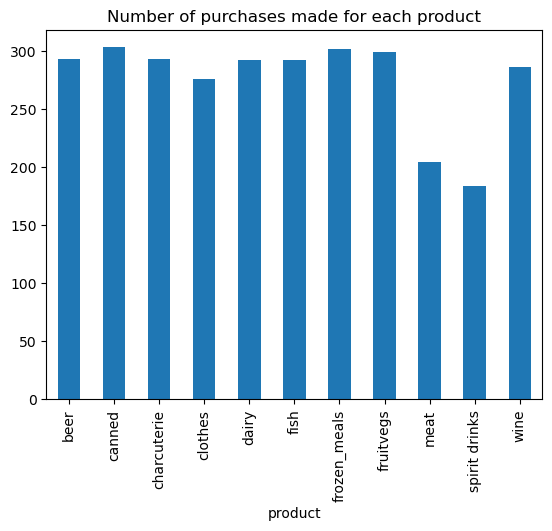

In [2]:
#If certain dataframses don't show up in the output, open it up as text editor
#The results are all there
# Exercise 1
#a) Number of costumers:

num_costumers = df['client'].nunique()
# print(df['client'].value_counts())
print(f"Number of unique costumers: {num_costumers}")

#Number of different types of products
num_products = df['product'].nunique()
print(f"Number of unique products: {num_products}")

#Number of shopping baskets
#Shopping basket = all purchases made by a single cliente in the same date
num_baskets = df.groupby(['client', 'date']).size().reset_index().shape[0]
print(f"Number of shoping baskets: {num_baskets}")

#Number of purchases of each product and let's visualize it (histogram)
num_purchases_product = df.groupby('product').size()
print(f"\nNumber of purchases for each product:\n{num_purchases_product}")
num_purchases_product.plot(kind='bar', title='Number of purchases made for each product')

#Number of products per shopping basket
num_products_per_basket = df.groupby(['client', 'date']).size()
print(f"\nNumber  of products per shopping basket:\n{num_products_per_basket}")

#Count of baskets according to the number of products sold in them
#So, baskets with 1 product, 2 products, ...
num_baskets_product_count = df.groupby(['client', 'date']).size().value_counts()

# Convert the Series to a DataFrame with labeled columns
num_baskets_product_count_df = num_baskets_product_count.reset_index()
num_baskets_product_count_df.columns = ['Num of Products in Basket', 'Count']
print()
print(num_baskets_product_count_df)

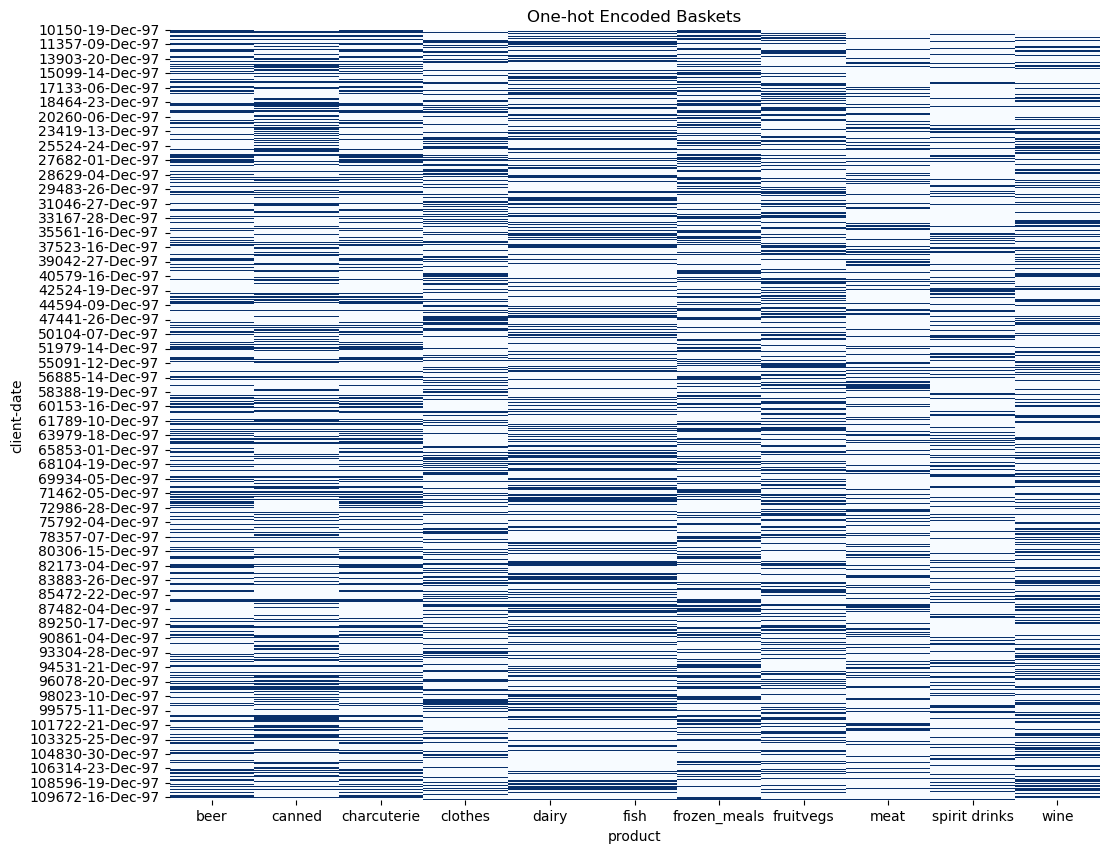

In [3]:
#b)
#With the data previously loaded create a basket object, with each basket described as a one-hot
#encoded and visualize it.

# Create a new column for one-hot encoding
df['one_hot'] = 1

# Pivot the table
basket_one_hot_data = df.pivot_table(index=['client', 'date'], columns='product', values='one_hot', fill_value=0)
# print(basket_one_hot)

plt.figure(figsize=(12, 10))
sns.heatmap(basket_one_hot_data, cbar=False, cmap="Blues")
plt.title("One-hot Encoded Baskets")
plt.show()


product           beer  canned  charcuterie  clothes  dairy  fish  \
client date                                                         
10150  19-Dec-97     0       0            0        0      0     0   
10236  07-Dec-97     1       0            1        0      0     0   
10360  08-Dec-97     1       1            1        0      1     1   
10451  05-Dec-97     1       1            1        1      0     0   
10609  13-Dec-97     0       0            0        0      1     1   
...                ...     ...          ...      ...    ...   ...   
109530 07-Dec-97     1       0            1        0      0     0   
109551 15-Dec-97     1       0            1        0      0     0   
109672 16-Dec-97     1       1            1        0      0     0   
109798 22-Dec-97     0       0            0        0      0     0   
109884 23-Dec-97     0       0            0        1      1     1   

product           frozen_meals  fruitvegs  meat  spirit drinks  wine  
client date                    

/home/joao/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


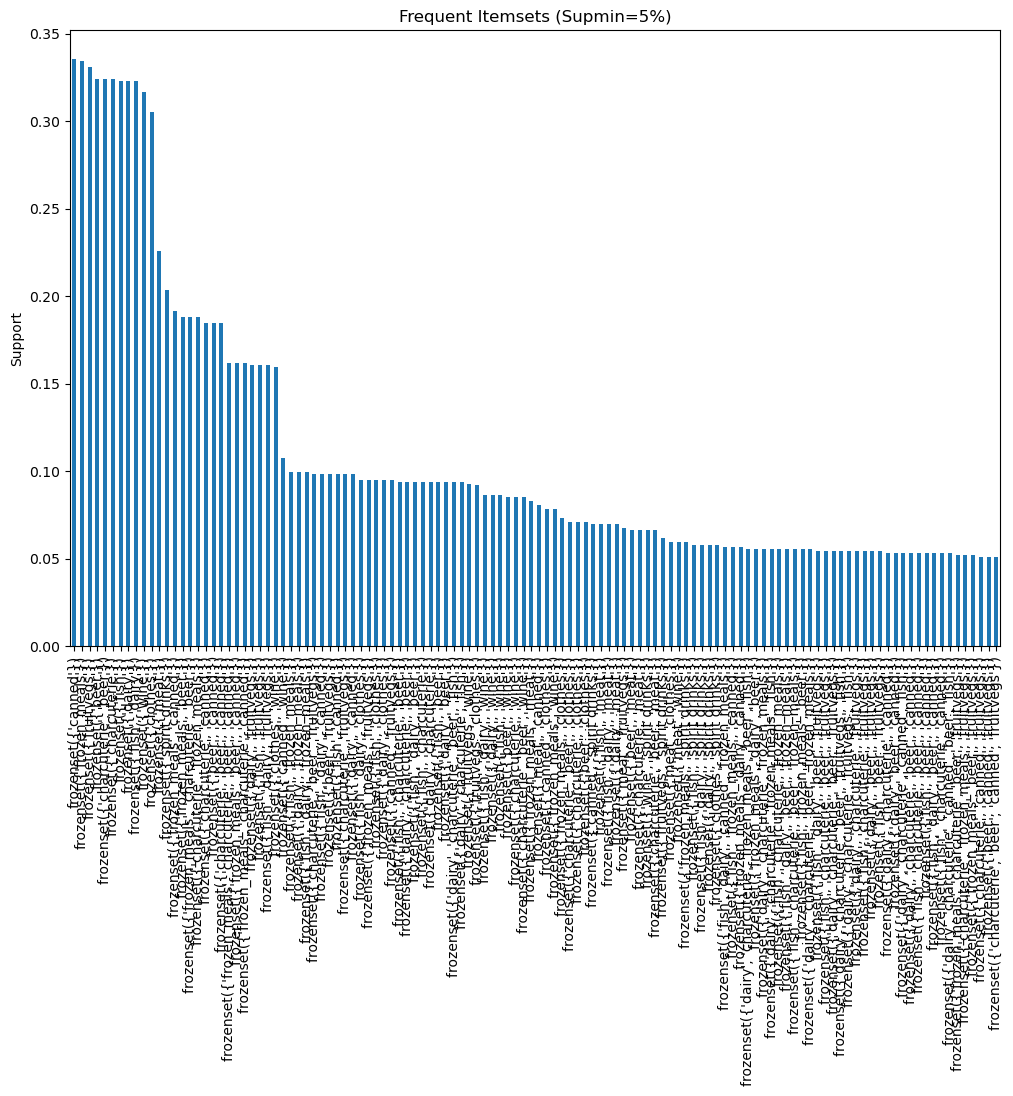

In [4]:
#c)
#Use the Apriori algorithm to obtain the frequent itemsets with Supmin = 5%. Visualize them.


basket_one_hot = df.pivot_table(index=['client', 'date'], columns='product', values='value', aggfunc='sum', fill_value=0)
basket_one_hot = basket_one_hot.applymap(lambda x: 1 if x > 0 else 0)

print(basket_one_hot)

frequent_itemsets = apriori(basket_one_hot, min_support=0.05, use_colnames=True)
print(frequent_itemsets)

# Sort the frequent itemsets by support:
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)

# Plot:
plt.figure(figsize=(12, 8))
frequent_itemsets['support'].plot(kind='bar', title="Frequent Itemsets (Supmin=5%)")
plt.xticks(range(len(frequent_itemsets)), frequent_itemsets['itemsets'], rotation=90)
plt.ylabel('Support')
plt.show()

In [5]:
#d)
#View frequent sets with 2 or more items and Supmin = 15%.

frequent_itemsets = apriori(basket_one_hot, min_support=0.15, use_colnames=True)

#filter the itemset to only have the ones with 2 or more items
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
filtered_itemsets = frequent_itemsets[frequent_itemsets['length'] >= 2]

print(filtered_itemsets)

     support                                   itemsets  length
11  0.184735                             (beer, canned)       2
12  0.324115                        (charcuterie, beer)       2
13  0.188053                       (frozen_meals, beer)       2
14  0.184735                      (charcuterie, canned)       2
15  0.191372                     (frozen_meals, canned)       2
16  0.188053                (charcuterie, frozen_meals)       2
17  0.159292                            (clothes, wine)       2
18  0.323009                              (fish, dairy)       2
19  0.160398                         (dairy, fruitvegs)       2
20  0.160398                          (fish, fruitvegs)       2
21  0.184735                (charcuterie, beer, canned)       3
22  0.161504               (frozen_meals, beer, canned)       3
23  0.188053          (frozen_meals, charcuterie, beer)       3
24  0.161504        (frozen_meals, charcuterie, canned)       3
25  0.160398                   (fish, da

/home/joao/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


/home/joao/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                              antecedents           consequents  \
0                           (charcuterie)                (beer)   
1                                  (beer)         (charcuterie)   
2                                  (fish)               (dairy)   
3                                 (dairy)                (fish)   
4                   (charcuterie, canned)                (beer)   
..                                    ...                   ...   
110  (fish, charcuterie, beer, fruitvegs)               (dairy)   
111       (dairy, charcuterie, fruitvegs)          (fish, beer)   
112              (dairy, beer, fruitvegs)   (fish, charcuterie)   
113        (fish, charcuterie, fruitvegs)         (dairy, beer)   
114               (fish, beer, fruitvegs)  (dairy, charcuterie)   

     antecedent support  consequent support   support  confidence       lift  \
0              0.324115            0.324115  0.324115         1.0   3.085324   
1              0.324115            

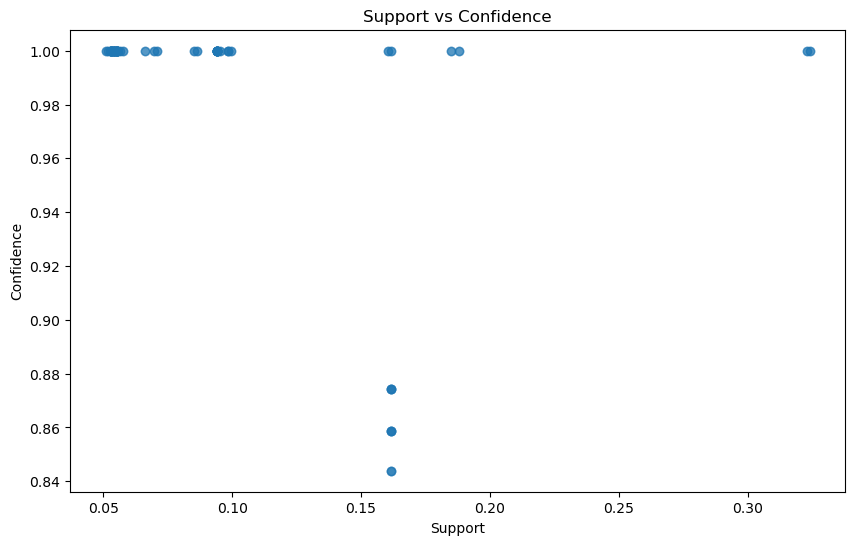

In [6]:
#e)
#Apply the Apriori algorithm to extract Association Rules with Confmin = 80%. Visualize them.

frequent_itemsets = apriori(basket_one_hot, min_support=0.05, use_colnames=True)  # Assuming a min support of 5% for the itemsets
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)
print(rules)

#visualization
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

In [7]:
#f)
# For the previously generated ruleset, view: 
# - the range of values for the Support, Confidence, Lift, Leverage and Conviction measures 
print('\nRange of values for Support, Confidence, Lift, Leverage and Conviction measures: ')
metrics = ['support', 'confidence', 'lift', 'leverage', 'conviction']
for metric in metrics:
    print(f"{metric.capitalize()}: {rules[metric].min()} - {rules[metric].max()}")


# - the 15 rules with the highest lift
print('\n15 rules with the highest Lift:') 
top_lift_rules = rules.sort_values(by='lift', ascending=False).head(15)
print(top_lift_rules)

# - rules supported by LHS > 15%, confidence > 95% and lift > 2.5 
print('\nrules supported by LHS > 15%, confidence > 95% and lift > 2.5: ')
filtered_rules = rules[(rules['antecedent support'] > 0.15) & (rules['confidence'] > 0.95) & (rules['lift'] > 2.5)]
print(filtered_rules)

# - rules that include the canned item in the rule consequent
print('\nrules that include the canned item in the rule consequent: ') 
canned_rules = rules[rules['consequents'].apply(lambda x: 'canned' in x)]
print(canned_rules)


# - rules that include the item fish and fruitvegs in the rule antecedent
print('\nrules that include the item fish and fruitvegs in the rule antecedent: ')
fish_fruitvegs_rules = rules[rules['antecedents'].apply(lambda x: 'fish' in x and 'fruitvegs' in x)]
print(fish_fruitvegs_rules)



Range of values for Support, Confidence, Lift, Leverage and Conviction measures: 
Support: 0.05088495575221239 - 0.3241150442477876
Confidence: 0.8439306358381503 - 1.0
Lift: 2.5622985827994564 - 10.63529411764706
Leverage: 0.034392376067037364 - 0.21906448234004228
Conviction: 4.330670272041954 - inf

15 rules with the highest Lift:
                            antecedents           consequents  \
114             (fish, beer, fruitvegs)  (dairy, charcuterie)   
106          (fish, frozen_meals, beer)  (dairy, charcuterie)   
95         (dairy, canned, charcuterie)          (fish, beer)   
96                (dairy, canned, beer)   (fish, charcuterie)   
98                 (fish, canned, beer)  (dairy, charcuterie)   
103  (dairy, frozen_meals, charcuterie)          (fish, beer)   
104         (dairy, frozen_meals, beer)   (fish, charcuterie)   
105   (fish, charcuterie, frozen_meals)         (dairy, beer)   
97          (fish, charcuterie, canned)         (dairy, beer)   
113      (fis

/home/joao/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


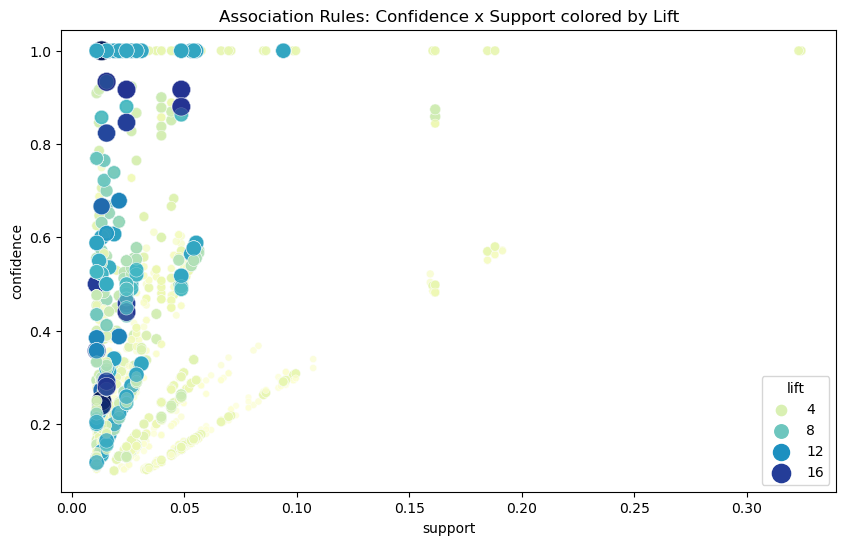

In [8]:
#g)
# Apply the Apriori algorithm again to extract Association Rules with Supmin = 1%, Confmin = 10% and 
# graphically visualize the Confidence × Support (Lift) rules

frequent_itemsets = apriori(basket_one_hot, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.10)

plt.figure(figsize=(10, 6))

# Specify size range for clarity in visualization
size_scale = (20, 200)

sns.scatterplot(data=rules, x="support", y="confidence", size="lift", hue="lift", palette="YlGnBu", sizes=size_scale, alpha=0.7)
plt.title("Association Rules: Confidence x Support colored by Lift")
plt.show()

In [9]:
#ex2
#It is intended to create a dataframe with data to develop a model that characterises consumers into three
# groups according to the products they purchase, for example baskets with:
# - Fruits and vegetables, dairy, fish, and meat => healthy;
# - frozen_meals, canned, charcuterie => lazy;
# - remaining => others

# For that:
# - With basket dataframe define the customer type accordingly with the products purchased.
# - With the cliente.txt file, build a dataframe that allows you to develop a model to characterise
# consumers.

In [10]:
#first let's create the basket dataframe:
baskets_df = df.groupby(['client', 'date'])['product'].apply(list).reset_index()
#print(baskets_df)

#let's have a function that classifies the basket based on it's products
healthy_products = ['fruitvegs', 'dairy', 'fish', 'meat']
lazy_products = ['frozen_meals', 'canned', 'charcuterie']
def classify_basket(products):
    if any(item in products for item in healthy_products):
        return 'healthy'
    elif any(item in products for item in lazy_products):
        return 'lazy'
    else:
        return 'others'
    
baskets_df['category'] = baskets_df['product'].apply(classify_basket)
print(baskets_df)

     client       date                                            product  \
0     10150  19-Dec-97                         [fruitvegs, spirit drinks]   
1     10236  07-Dec-97                  [beer, frozen_meals, charcuterie]   
2     10360  08-Dec-97  [charcuterie, fish, frozen_meals, canned, beer...   
3     10451  05-Dec-97  [beer, clothes, frozen_meals, charcuterie, can...   
4     10609  13-Dec-97                           [fish, dairy, fruitvegs]   
..      ...        ...                                                ...   
899  109530  07-Dec-97                                [beer, charcuterie]   
900  109551  15-Dec-97                          [beer, wine, charcuterie]   
901  109672  16-Dec-97    [wine, frozen_meals, charcuterie, beer, canned]   
902  109798  22-Dec-97                                     [frozen_meals]   
903  109884  23-Dec-97  [meat, frozen_meals, fruitvegs, fish, spirit d...   

    category  
0    healthy  
1       lazy  
2    healthy  
3       lazy  


In [11]:

#Now let's the clientes.txt to a dataframe
clients_df = pd.read_csv('clientes.txt', delimiter='\t')
print(clients_df)

     client sex ownhome  salary  age
0     39808   M       N   27000   46
1     67362   F       N   30000   28
2     10872   M       N   13200   36
3     26748   F       N   12200   26
4     91609   M       Y   11000   24
..      ...  ..     ...     ...  ...
995   31384   M       N   27500   27
996   63996   F       N   22600   23
997   99025   M       Y   27400   42
998   95921   F       Y   23300   43
999   99164   M       N   21600   26

[1000 rows x 5 columns]


In [12]:
#let's merge both dataframes (client column is the same on both ones)
#clientes.txt has 1000 rows, so the merged dataframe is gona have some missing values
combined_df = clients_df.merge(baskets_df, on='client', how='left')
combined_df.fillna({
    'date': 'unknown',
    'product': 'unknown',
    'category': 'unknown'
}, inplace=True)
#print(combined_df.isnull().sum())
print(combined_df.columns.tolist())

['client', 'sex', 'ownhome', 'salary', 'age', 'date', 'product', 'category']


In [13]:
#let's prepare the data to be make the model
combined_df['sex'] = combined_df['sex'].map({'M': 0, 'F': 1})  
combined_df['ownhome'] = combined_df['ownhome'].map({'N': 0, 'Y': 1}) 

#clientes.txt has information about clients that have no baskets associated. Let's drop these clients
combined_df = combined_df[combined_df['category'] != 'unknown']

#one-hot encoding for the 3 categories
# category_dummies = pd.get_dummies(combined_df['category'], prefix='category')
# combined_df = pd.concat([combined_df, category_dummies], axis=1)
combined_df.drop(columns=['date', 'product'], inplace=True)
#drop client
combined_df = combined_df.drop(columns=['client'])


print(combined_df)

     sex  ownhome  salary  age category
0      0        0   27000   46   others
1      1        0   30000   28   others
2      0        0   13200   36  healthy
3      1        0   12200   26   others
5      1        0   15000   35  healthy
..   ...      ...     ...  ...      ...
994    0        0   10300   29  healthy
995    0        0   27500   27     lazy
996    1        0   22600   23  healthy
998    1        1   23300   43  healthy
999    0        0   21600   26   others

[904 rows x 5 columns]


In [14]:
#let's make the models taht predict the client's category based on features (sex, ownhome, salary and age)
X = combined_df[['sex', 'ownhome', 'salary', 'age']]
y = combined_df['category']

#Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
#Model building (let's use random forests)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Model evaluation (let's see it's accuracy)
y_pred = clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy for Random Forest: {accuracy_rf * 100:.2f}%")

Accuracy for Random Forest: 49.17%


In [26]:
#model building / decisions trees
clf_decision_tree = tree.DecisionTreeClassifier(random_state=42)
clf_decision_tree.fit(X_train, y_train)

#model evaluation
y_pred_dt = clf_decision_tree.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"Accuracy for Decisions Trees: {accuracy_dt * 100:.2f}%")


Accuracy for Decisions Trees: 51.38%


In [17]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
clf = LogisticRegression(random_state=42, max_iter=5000)  # max_iter may need to be adjusted based on convergence
clf.fit(X_train_scaled, y_train)

# Predict and Evaluate
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 58.56%
